In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('data/forex_data.csv', index_col = 'Date')


In [3]:
data.head()

,AUDCAD=X,AUDCHF=X,AUDEUR=X,AUDGBP=X,AUDJPY=X,AUDNZD=X,AUDUSD=X,CADAUD=X,CADCHF=X,CADEUR=X,...,NZDAUD=X,NZDCAD=X,NZDCHF=X,NZDEUR=X,NZDGBP=X,NZDJPY=X,NZDUSD=X,USDCAD=X,USDCHF=X,USDJPY=X
Date,,,,,,,,,,,,,,,,,,,,,
2014-06-30,1.00410,0.83880,0.6900,0.5526,95.497803,1.07250,0.941708,0.99545,0.83510,0.68702,...,0.93138,0.93560,0.78160,0.6430,0.51484,88.994003,0.877578,1.06655,0.89100,101.443001
2014-07-01,1.00600,0.83580,0.6886,0.5510,95.475197,1.07540,0.942951,0.99381,0.83070,0.68415,...,0.92894,0.93493,0.77675,0.6399,0.51210,88.750000,0.876271,1.06710,0.88673,101.290001
2014-07-02,1.00927,0.84226,0.6937,0.5534,96.362297,1.08304,0.949217,0.99031,0.83423,0.68716,...,0.92270,0.93178,0.77750,0.6404,0.51090,88.970001,0.876271,1.06338,0.88748,101.540001
2014-07-03,1.00613,0.83888,0.6909,0.5496,96.063004,1.07606,0.943485,0.99342,0.83347,0.68645,...,0.92869,0.93488,0.77925,0.6419,0.51070,89.250999,0.876578,1.06666,0.88919,101.830002
2014-07-04,0.99430,0.83490,0.6870,0.5450,95.526901,1.06830,0.935016,1.00520,0.83964,0.69069,...,0.93509,0.93010,0.78100,0.6426,0.50990,89.382004,0.874661,1.06365,0.89327,102.180000


## Step 1 - Dimensionality Reduction



### Using PCA to find a compact representation for each security

- Extracts common underlying risk factors from securities’ returns;
- Produces a compact representation for each security;

Before applying PCA, the pricing data needs to be converted to returns and then normalized by subtracting the mean and dividing by the standard deviation, as follows:

Returns 

$$ R_{i, t} = \frac{P_{i,t} - P_{i,t-1}} {P_{i,t-1}} $$


Data Normalization

$$ Y_{i} =  \frac{R_{i} - \bar{R_{i}}} {\sigma_{i}} $$

Decomposition

By applying PCA, $A$ is decomposed into the resulting eigenvectors and eigenvalues. An $n$ number of eigenvectors is selected where $n$ represents the number of features to describe the transformed data. The matrix containing the eigenvalues is set as the feature vector. The final dataset is obtained by multiplying the original matrix A by the feature vector.

[0.26027606 0.1591565  0.14362117 0.10781052 0.08683108]


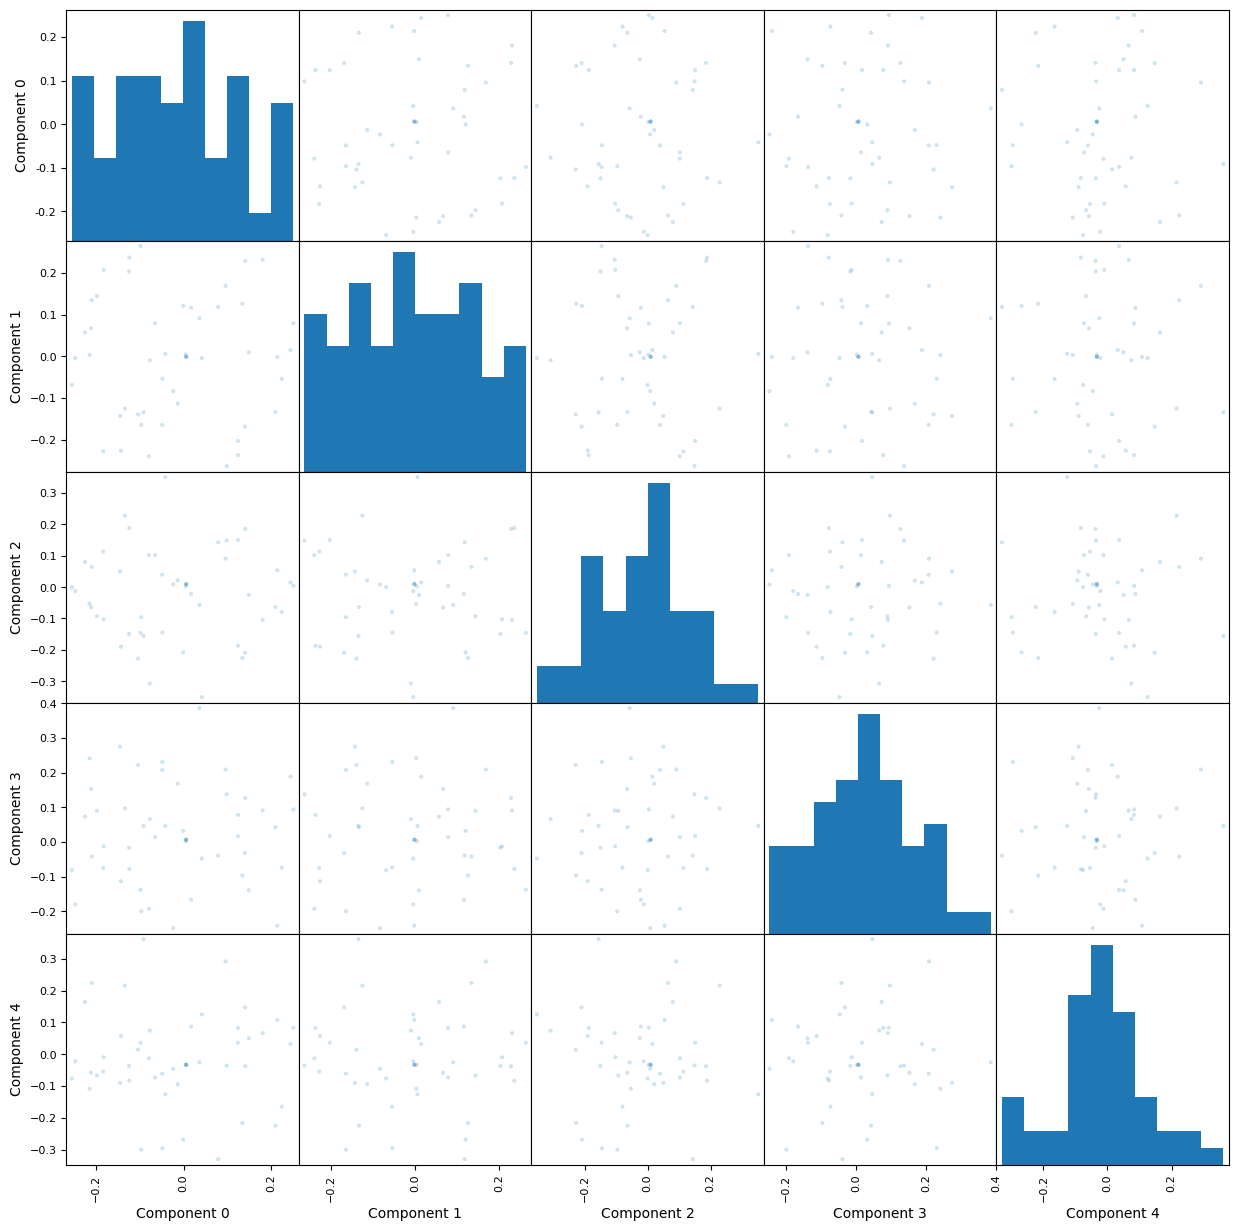

In [4]:
from clustering import Clustering

ps = Clustering(data)

# Here the first parameter is the number of features to reduce to.
pca = ps.pca(5)
print(pca.explained_variance_ratio_)

# The following will plot the feature vector from the previous method call.
ps.plot_pca_matrix()

The first 5 components explain 75.7% of the total variance.

In [5]:
pca.explained_variance_ratio_.sum()

0.7576953228075538